In [12]:
# load the deepforest prebuilt crown model and run it on a single image
from deepforest import main
from deepforest import get_data
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image


In [15]:
model = main.deepforest()
model.use_release()

# load the image
image_path = get_data("OSBS_029.tif")
# image_path = "/Users/philblecher/Desktop/Github/BioAI/test_imgs/51.png"
# image_path = "/Users/philblecher/Desktop/Github/BioAI/test_imgs/example.tif"
# 51.457916, -2.637450
# image = plt.imread(image_path)
# open tif image
# image = Image.open(image_path)
# image = np.array(image)
# plt.imshow(image)

# run the model
predictions = model.predict_image(path=image_path)
predictions.head()



Reading config file: /Users/philblecher/opt/miniconda3/envs/deepforest/lib/python3.12/site-packages/deepforest/data/deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


,xmin,ymin,xmax,ymax,label,score,image_path
0,330.0,342.0,373.0,391.0,Tree,0.802979,OSBS_029.tif
1,216.0,206.0,248.0,242.0,Tree,0.778803,OSBS_029.tif
2,325.0,44.0,363.0,82.0,Tree,0.751573,OSBS_029.tif
3,261.0,238.0,296.0,276.0,Tree,0.748605,OSBS_029.tif
4,173.0,0.0,229.0,33.0,Tree,0.738210,OSBS_029.tif


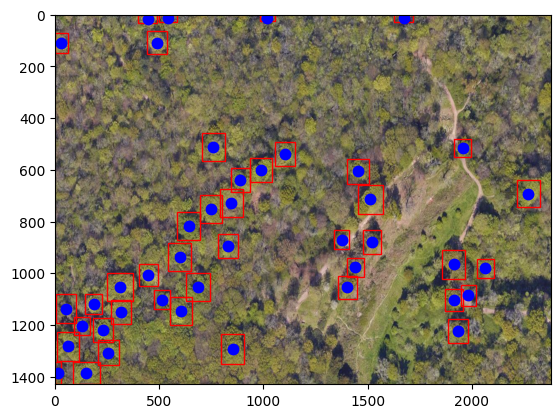

In [4]:
# plot the image and the predictions
fig, ax = plt.subplots()
# stretch the image so that it is displayed correctly
ax.imshow(image, aspect="auto")
# plot the bounding boxes
for i in range(len(predictions)):
    x, y, w, h = predictions["xmin"][i], predictions["ymin"][i], predictions["xmax"][i], predictions["ymax"][i]
    rect = plt.Rectangle((x, y), w-x, h-y, fill=False, color="red")
    ax.add_patch(rect)
    # scatter points on the image, scale the scatter points fit the same scale as the image
    ax.scatter(predictions["xmin"][i] + (predictions["xmax"][i] - predictions["xmin"][i]) / 2,
                predictions["ymin"][i] + (predictions["ymax"][i] - predictions["ymin"][i]) / 2,   
                color="blue", linewidths=2.5, edgecolors="blue")


plt.show()





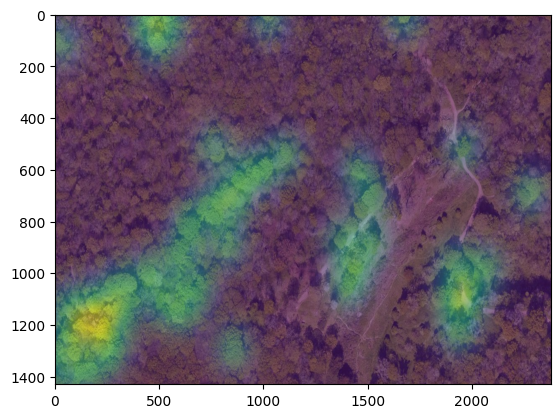

In [5]:
# transform the scatter into a density map
# create a grid of points
x_size = np.linspace(0, image.shape[1], image.shape[1])
y_size = np.linspace(0, image.shape[0], image.shape[0])
X, Y = np.meshgrid(x_size, y_size)
# create a density map
Z = np.zeros(X.shape)
for i in range(len(predictions)):
    x, y = (predictions["xmin"][i] + predictions["xmax"][i]) / 2, (predictions["ymin"][i] + predictions["ymax"][i]) / 2
    Z += np.exp(-((X - x)**2 + (Y - y)**2) / 10000) # the 1000 is a hyperparameter that controls the spread of the density map


fig, ax = plt.subplots()
ax.imshow(Z, aspect="auto")
ax.imshow(image, aspect="auto", alpha=0.5)
plt.show()


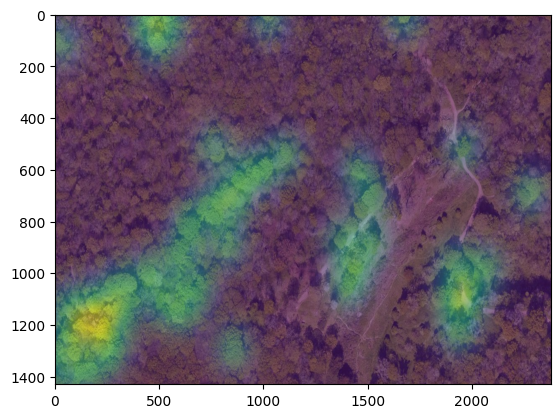

In [9]:
import ee
ee.Authenticate()

In [8]:
ee.Initialize()
dataset = ee.Image("CGIAR/SRTM90_V4")
elevation = dataset.select("elevation")

# get the bounding box of the image
centre_coords = [ -2.637450, 51.457916]

box_width = 0.005
bounding_box = ee.Geometry.Rectangle([centre_coords[0] - box_width, centre_coords[1] - box_width, centre_coords[0] + box_width, centre_coords[1] + box_width])


# extract satellite image of the area
image_collection = ee.ImageCollection("COPERNICUS/S2")
image_collection = image_collection.filterBounds(bounding_box)
image_collection = image_collection.filterDate("2023-01-01", "2024-12-31")
# image_collection = image_collection.sort()
image = image_collection.first()

# get the image
image = image.visualize(**{
    "bands": ["B4", "B3", "B2"],
    "min": 1000,
    "max": 5000,
})

# resample the image with a resolution of 1m
res = 0.1
image = image.resample("bilinear").reproject(crs= image.projection(), scale=res)


# extract values from the image
image = image.updateMask(image.mask().reduce("min"))


# show the image with ee
print(ee.Image(image).getThumbUrl({
    "region": bounding_box.getInfo()["coordinates"],
    "dimensions": "1500x1500"
}))


elevation_clip = elevation.clip(bounding_box)

res = 10

resampled = elevation_clip.resample("bilinear").reproject(crs= elevation_clip.projection(), scale=res)

opacity = 0.9

vis_params = {
    "min": 0,
    "max": 300,
    "opacity": opacity
}

# get the image
image = resampled.visualize(**vis_params)

# show the image with ee
print(ee.Image(image).getThumbUrl({
    "region": bounding_box.getInfo()["coordinates"],
    "dimensions": "1500x1500"
}))



True